In [10]:
%matplotlib inline

In [16]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
brisk = cv2.BRISK_create()

## Detecção de Keypoints

- Detectar os keypints (pontos de interesse) da imagem com o objeto

2733


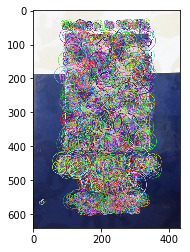

(<matplotlib.image.AxesImage at 0x7f095dbfbcd0>, None)

In [12]:
img_obj = cv2.imread('book.jpg')

gray_obj = cv2.cvtColor(img_obj, cv2.COLOR_BGR2GRAY)

kp_obj = brisk.detect(gray_obj, None)

print len(kp_obj)

cv2.drawKeypoints(img_obj, kp_obj, img_obj, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img_obj_out = cv2.cvtColor(img_obj, cv2.COLOR_BGR2RGB)
plt.imshow(img_obj_out, 'gray'),plt.show()

- Detectar os pontos de interesse (keypoints) da imagem da cena que pode conter o objeto

3061


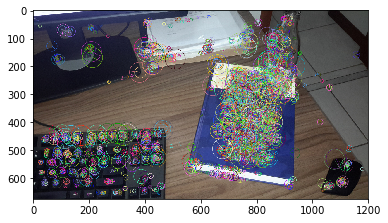

(<matplotlib.image.AxesImage at 0x7f095db885d0>, None)

In [13]:
img_cena = cv2.imread('cena2.jpg')

gray_cena = cv2.cvtColor(img_cena,cv2.COLOR_BGR2GRAY)

kp_cena = brisk.detect(gray_cena,None)
print len(kp_cena)

cv2.drawKeypoints(img_cena, kp_cena, img_cena, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img_cena_out = cv2.cvtColor(img_cena, cv2.COLOR_BGR2RGB)
plt.imshow(img_cena_out, 'gray'),plt.show()

## Extração do descritores 

- Para cada keypoint detectado, extrair os descritores para representá-los

In [14]:
brisk = cv2.BRISK_create()

# descritores do objeto
(kp_obj, des_obj) = brisk.compute(gray_obj, kp_obj)

# descritores da cena
(kp_cena, des_cena) = brisk.compute(gray_cena, kp_cena)

print des_obj.shape
print des_cena.shape


(2733, 64)
(3061, 64)


Mostrando os descritores de dois keypoints do objeto escolhidos aleatoriamente 

NameError: name 'des' is not defined

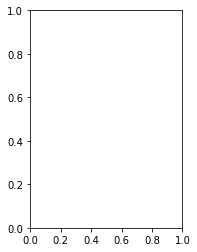

In [17]:
for i in xrange(2):
    plt.subplot(1,2,i+1)
    kp_index = np.random.randint(0,len(kp_obj))
    plt.bar(np.arange(64), des[kp_index,:])
    plt.title('keypoint {}'.format(kp_index))
    
plt.show()

Busca do conjunto com os keypoints correspondentes entre a imagem do objeto e da cena. Note que a correspondência é feita casando os descritores.

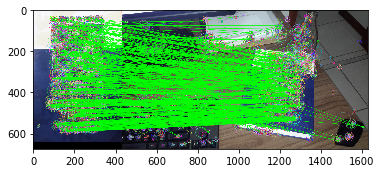

(<matplotlib.image.AxesImage at 0x7f095d562a50>, None)

In [18]:
bf= cv2.BFMatcher()
matches = bf.knnMatch(des_obj, des_cena, k=2)

good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)
            
draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = None,
                   flags = 2)

img3 = cv2.drawMatches(img_obj, kp_obj, img_cena, kp_cena, good, None, **draw_params)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

plt.imshow(img3, 'gray'),plt.show()

### Estimando a Homografia


In [19]:
MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_obj[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_cena[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    M_all_points, mask_all_points = cv2.findHomography(src_pts, dst_pts) 
    
    print M
    print M_all_points

    matchesMask = mask.ravel().tolist()

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

[[  5.68161578e-01  -3.04535760e-01   6.57666658e+02]
 [  5.91362051e-02   3.81244983e-01   1.88427248e+02]
 [ -9.34090564e-05  -3.07743518e-04   1.00000000e+00]]
[[ -2.41270824e-01  -3.11881984e+00   7.46051087e+02]
 [ -1.14673152e-01  -1.63078588e+00   3.87461419e+02]
 [ -3.12038114e-04  -4.18747972e-03   1.00000000e+00]]


### Pojeção do retângulo correspondente ao objeto

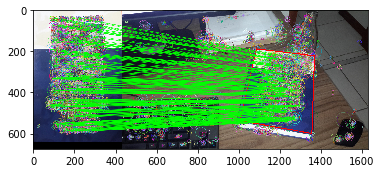

In [20]:
 if matchesMask != None:
    h,w = gray_obj.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)

    img_cena = cv2.polylines(img_cena,[np.int32(dst)],True,(0,0, 255),3)

    draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = None,
                   matchesMask = matchesMask, 
                   flags = 2)

    img3 = cv2.drawMatches(img_obj, kp_obj, img_cena, kp_cena, good, None, **draw_params)
    img3_out = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

    plt.imshow(img3_out, 'gray'),plt.show()